Notebook objective: Train, tune & test LightGBM model, target encoding the country variable & using year as a numeric variable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
#from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor, early_stopping

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Create CV splitters
cv_outer = GroupKFold(n_splits = 4)
cv_inner = GroupKFold(n_splits = 3)

In [7]:
# Create target encoder
encoder = TargetEncoder(cols = "country")

## Nested crossvalidation

In [10]:
# Initialize lists to store testing results
test_list = []
preds_list = []
resids_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [11]:
# Perform nested crossvalidation

# Outer loop
for i, (train_index, test_index) in enumerate(cv_outer.split(X = X, groups = X.country)):

    # Split train - test
    X_train, y_train = X.iloc[train_index, ], y[train_index]
    X_test, y_test = X.iloc[test_index, ], y[test_index]

    # Define tuning objective
    def objective_lgbm(trial):

        # Define hyperparameter space
        learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
        num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
        min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
        min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
        reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
        reg_lambda = trial.suggest_float("l2_reg", 0, 2)
        subsample = trial.suggest_float("subsample", 0.5, 1)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)
    
        # Store tuning scores & number of rounds
        scores = []
        rounds = []

        # Inner loop (hyperparameter tuning)
        for k, (inner_index, val_index) in enumerate(cv_inner.split(X = X_train, groups = X_train.country)):
    
            # Split innertrain - val
            X_inner, y_inner = X.iloc[inner_index, ], y[inner_index]
            X_val, y_val = X.iloc[val_index, ], y[val_index]
    
            # Perform target encoding
            X_inner = encoder.fit_transform(X_inner, y_inner)
            X_val = encoder.transform(X_val)
        
            # Create model
            if k == 0:
                callbacks = [
                    optuna.integration.LightGBMPruningCallback(trial, "l2"),
                    early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
                ]
            else:
                callbacks = [
                    early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
                ]
        
            model = LGBMRegressor(
                boosting_type = "gbdt",
                num_threads = 10,
                device_type = "gpu",
                random_state = random_state,
                n_estimators = 5000,
                verbosity = -1,
                learning_rate = learning_rate,
                num_leaves = num_leaves,
                min_child_samples = min_child_samples,
                min_child_weight = min_child_weight,
                reg_alpha = reg_alpha,
                reg_lambda = reg_lambda,
                subsample = subsample,
                subsample_freq = 1,
                colsample_bytree = colsample_bytree
            )
    
            # Train model with early stopping
            model.fit(
                X_inner, 
                y_inner, 
                eval_set = [(X_val, y_val)],
                callbacks = callbacks)
    
            # Record best number of rounds
            rounds.append(model.best_iteration_)
    
            # Record best score
            scores.append(model.best_score_['valid_0']['l2'])
    
        # Report mean number of rounds
        trial.set_user_attr("n_rounds", (np.mean(rounds)))
        
        return np.mean(scores)

    # Create & perform tuning study
    study_lgbm = optuna.create_study(
        sampler = optuna.samplers.TPESampler(seed = random_state),
        pruner = optuna.pruners.HyperbandPruner(),
        study_name = "tune_lgbm",
        direction = "minimize"
    )

    optuna.logging.set_verbosity(optuna.logging.ERROR)
    study_lgbm.optimize(
      objective_lgbm, 
      n_trials = 250,
      show_progress_bar = True)

    # Retrieve best tune
    best_tune = study_lgbm.trials_dataframe().sort_values("value", ascending = True)
    best_tune = best_tune[best_tune["state"] == "COMPLETE"].iloc[0]

    # Preprocess features
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)

    # Train LGBM model
    model = LGBMRegressor(
        boosting_type = "gbdt",
        random_state = random_state,
        subsample_freq = 1,
        verbosity = -1,
        importance_type = "gain",
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        learning_rate = best_tune["params_learning_rate"],
        num_leaves = best_tune["params_num_leaves"],
        min_child_samples = best_tune["params_min_child_samples"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

    model.fit(X_train, y_train)

    # Save actual values
    test_list.append(y_test)

    # Make predictions on test data
    preds = model.predict(X_test)
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_test - preds
    resids_list.append(resids)

    # Calculate scores
    mse = mean_squared_error(y_test, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_test, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_test, preds)
    scores_mape.append(mape)


Best trial: 192. Best value: 12.021: 100%|███████████████████████████████████████████| 250/250 [01:04<00:00,  3.86it/s]
Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\PanelLifeExpectancy\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
Best trial: 179. Best value: 17.2777: 100%|██████████████████████████████████████████| 250/250 [00:54<00:00,  4.58it/s]


In [12]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
19.548
RMSE:
4.414
MAPE:
0.0533


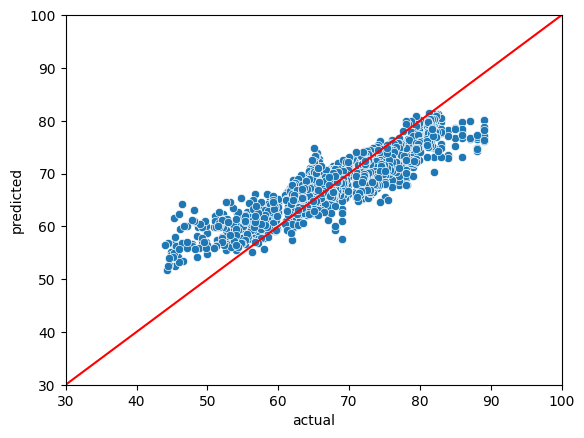

In [16]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(test_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

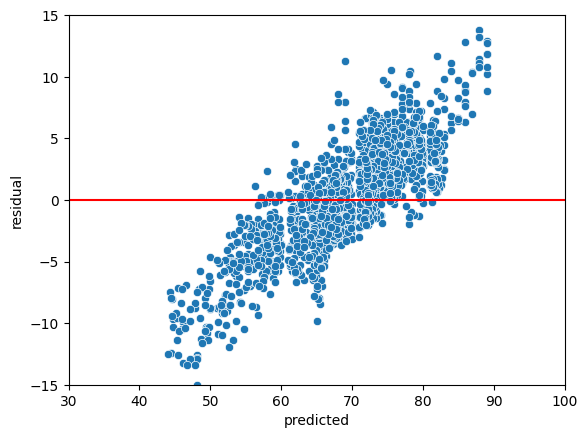

In [17]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(test_list).ravel(), 
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-15, 15)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

## Final hyperparameter tuning

In [18]:
# Objective function
def objective_lgbm(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Store tuning scores & number of rounds
    scores = []
    rounds = []

    for i, (train_index, val_index) in enumerate(cv_outer.split(X = X, groups = X["country"])):

        # Split train - val
        X_train, y_train = X.iloc[train_index, ], y[train_index]
        X_val, y_val = X.iloc[val_index, ], y[val_index]

        # Perform target encoding
        X_train = encoder.fit_transform(X_train, y_train)
        X_val = encoder.transform(X_val)
    
        # Create model
        if i == 0:
            callbacks = [
                optuna.integration.LightGBMPruningCallback(trial, "l2"),
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
        else:
            callbacks = [
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
    
        model = LGBMRegressor(
            boosting_type = "gbdt",
            num_threads = 10,
            device_type = "gpu",
            random_state = random_state,
            n_estimators = 5000,
            verbosity = -1,
            learning_rate = learning_rate,
            num_leaves = num_leaves,
            min_child_samples = min_child_samples,
            min_child_weight = min_child_weight,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            subsample = subsample,
            subsample_freq = 1,
            colsample_bytree = colsample_bytree
        )

        # Train model with early stopping
        model.fit(
            X_train, 
            y_train, 
            eval_set = [(X_val, y_val)],
            callbacks = callbacks)

        # Record best number of rounds
        rounds.append(model.best_iteration_)

        # Record best score
        scores.append(model.best_score_['valid_0']['l2'])

    # Report mean number of rounds
    trial.set_user_attr("n_rounds", (np.mean(rounds)))
    
    return np.mean(scores)


In [19]:
# Create study
study_lgbm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lgbm",
  direction = "minimize"
)

In [20]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lgbm.optimize(
  objective_lgbm, 
  n_trials = 500,
  show_progress_bar = True)

Best trial: 291. Best value: 17.1357: 100%|██████████████████████████████████████████| 500/500 [01:42<00:00,  4.89it/s]


In [21]:
# Save tuning log
trials_lgbm = study_lgbm.trials_dataframe().sort_values("value", ascending = True)
trials_lgbm.to_csv("./OutputData/trials_lgbm.csv", index = False)

## Diagnostics & inference

In [22]:
# Load best 5 tunes
best_tunes = pd.read_csv("./OutputData/trials_lgbm.csv")
best_tunes = best_tunes[best_tunes["state"] == "COMPLETE"].iloc[0:5]
best_tune = best_tunes.iloc[0]

In [23]:
best_tunes

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_l1_reg,params_l2_reg,params_learning_rate,params_min_child_samples,params_min_child_weight,params_num_leaves,params_subsample,user_attrs_n_rounds,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,state
0,291,17.135668,2023-12-13 17:32:51.308980,2023-12-13 17:32:51.874068,0 days 00:00:00.565088,0.250193,0.000096,1.901950,0.253085,194,10,903,0.893013,23.500000,57.685968,38.658045,22.713378,18.332091,COMPLETE
1,267,17.225776,2023-12-13 17:32:43.393076,2023-12-13 17:32:44.020244,0 days 00:00:00.627168,0.263200,0.000091,1.848394,0.252509,195,14,979,0.894576,22.750000,57.787613,38.748982,22.923580,18.949445,COMPLETE
2,285,17.233298,2023-12-13 17:32:49.167778,2023-12-13 17:32:49.750846,0 days 00:00:00.583068,0.250524,0.000199,1.879527,0.250263,197,11,928,0.910071,21.750000,58.012085,38.609163,22.814625,18.306098,COMPLETE
3,434,17.383916,2023-12-13 17:33:22.302996,2023-12-13 17:33:22.987558,0 days 00:00:00.684562,0.250970,0.000181,1.163571,0.216865,200,13,984,0.896123,23.750000,17.906141,NaN,NaN,NaN,COMPLETE
4,268,17.476667,2023-12-13 17:32:44.021244,2023-12-13 17:32:44.596794,0 days 00:00:00.575550,0.263861,0.000123,1.879251,0.248411,198,12,987,0.898582,23.750000,58.245733,39.299616,23.148178,18.790660,COMPLETE


In [24]:
# Preprocess data for final model
X_train = encoder.fit_transform(X, y)
y_train = y.copy()

In [25]:
# Train final model
model = LGBMRegressor(
        boosting_type = "gbdt",
        random_state = random_state,
        subsample_freq = 1,
        verbosity = -1,
        importance_type = "gain",
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        learning_rate = best_tune["params_learning_rate"],
        num_leaves = best_tune["params_num_leaves"],
        min_child_samples = best_tune["params_min_child_samples"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.250193251527037, importance_type='gain',
              learning_rate=0.2530849171971484, min_child_samples=194,
              min_child_weight=10, n_estimators=23, num_leaves=903,
              random_state=1923, reg_alpha=9.587573693093282e-05,
              reg_lambda=1.901950325902696, subsample=0.8930126843264574,
              subsample_freq=1, verbosity=-1)

In [26]:
# Get fitted values & residuals
fitted = model.predict(X_train)
resids = y_train - fitted

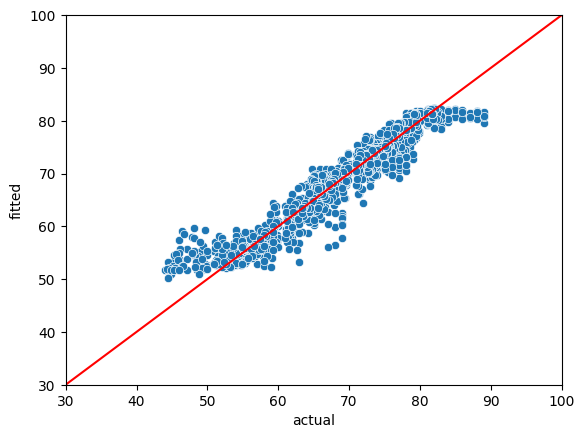

In [27]:
# Plot fitted vs. actual
_ = sns.scatterplot(x = y_train, y = fitted)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

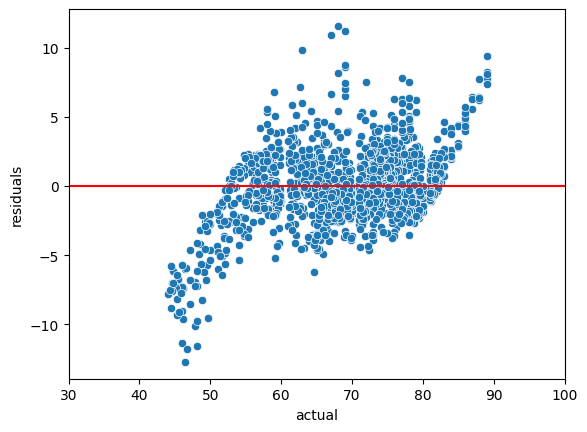

In [30]:
# Plot fitted vs. resids
_ = sns.scatterplot(x = y_train, y = resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("residuals")

In [31]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

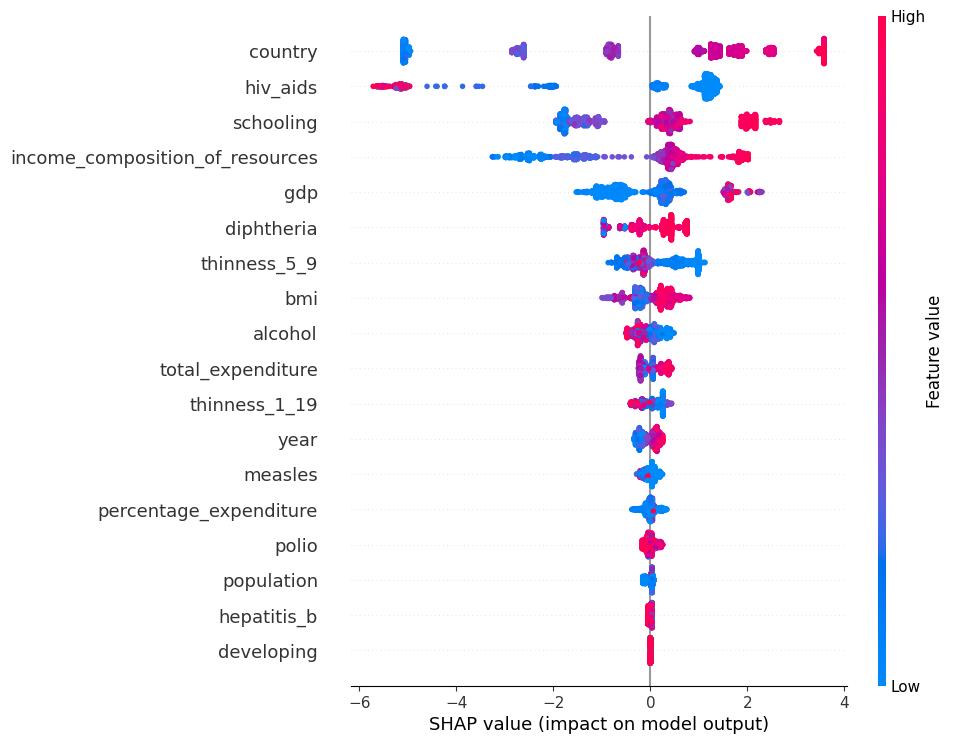

In [32]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

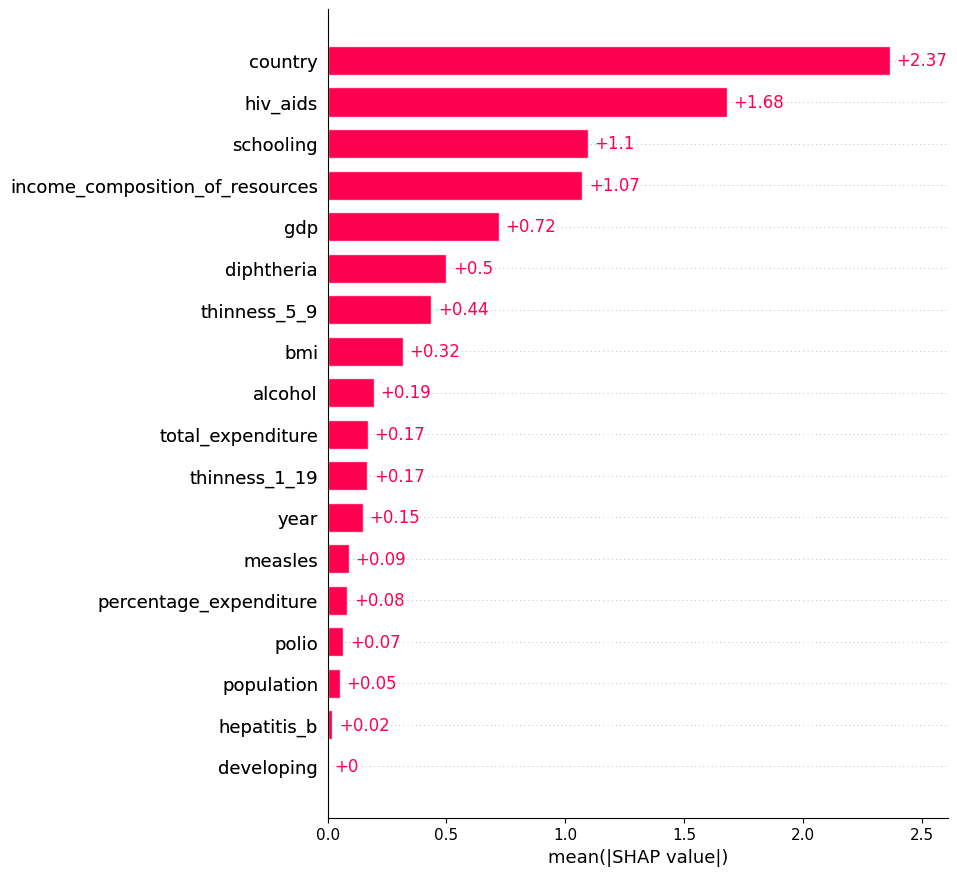

In [33]:
shap.plots.bar(shap_values, max_display = 20)